# Cheat sheet - Option Pricing with Black-Scholes

### by François Goujon

Black-Scholes : 

$Call = S \mathcal{N}(d_1) - e^{-rT}K \mathcal{N}(d_2)$ <br>
$Put = - S \mathcal{N}(-d_1) + e^{-rT}K \mathcal{N}(-d_2)$

Where : $d_1 = \frac{1}{\sigma\sqrt{T}} (\log(\frac{S}{K}) + (r + \frac{\sigma^2}{2})t) \ $ and $ \ d_2 = d_1 - \sigma\sqrt{T}$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Functions

In [320]:
def d1(s, k, sigma, t, r):
    return (np.log(s/k) + (r + (sigma**2)/2)*t)/(sigma*np.sqrt(t))

def d2(s, k, sigma, t, r):
    return d1(s, k, sigma, t, r) - sigma*np.sqrt(t)

def call(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(T)
    return s*norm.cdf(d1_) - k*np.exp(-r*t)*norm.cdf(d2_)

def put(s, k, sigma, t, r):
    d1_ = d1(s, k, sigma, t, r)
    d2_ = d1_ - sigma*np.sqrt(T)
    return - s*norm.cdf(-d1_) + k*np.exp(-r*t)*norm.cdf(-d2_)

def proba_call_ITM(s, k, sigma, t, r):
    d2_ = d2(s, k, sigma, t, r)
    return norm.cdf(d2_)

def proba_put_ITM(s, k, sigma, t, r):
    d2_ = d2(s, k, sigma, t, r)
    return norm.cdf(-d2_)

def plot_premium_strike(s, sigma, t, r):
    ks = np.arange(0.005*s, 2*s, 0.005*s)
    call_prms = list(map(lambda x : call(s, x, sigma, t, r), ks))
    put_prms = list(map(lambda x : put(s, x, sigma, t, r), ks))
    plt.figure(figsize=(12,6))
    plt.plot(ks, call_prms, label='Call premium', c = "g")
    plt.plot(ks, put_prms, label='Put premium', c = "r")
    plt.axvline(x=s, c="b", label = "S0")
    plt.xlabel("Strike")
    plt.ylabel("Premium")
    plt.legend()
    plt.grid()
    plt.show()
    return ks, call_prms, put_prms

def plot_payoff(s, k, sigma, t, r, ret = False):
    pc = call(s, k, sigma, t, r)
    pp = put(s, k, sigma, t, r)
    pc_T = pc*np.exp(r*t)
    pp_T = pp*np.exp(r*t)
    
    sts = np.arange(0, 2*s, 0.005*s)
    call_po = np.array(list(map(lambda x : max(x-k,0) - pc_T, sts)))
    put_po = np.array(list(map(lambda x : max(k-x,0) - pp_T, sts)))
    call_put = call_po - put_po
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 15))
    ax1.plot(sts, call_po, label = "Payoff call", c = "g")
    ax1.plot(sts, put_po, label = "Payoff put", c = "r")
    ax2.plot(sts, call_put, label = "Call - Put payoff", c = "black")
    ax2.plot(sts, call_po, label = "Call payoff", c = "g")
    ax2.plot(sts, -put_po, label = "Put sell payoff", c = "r")
    for ax in [ax1, ax2]:
        ax.axvline(x=s, c="b", label = "S0")
        ax.axvline(x=k, c="deeppink", label = "K")
        ax.set_xlabel(r"$S_T$")
        ax.set_ylabel("PF Value at t = T")
        ax.legend()
        ax.grid()
    plt.show()
    if ret:
        return sts, call_po, put_po, call_put
    
def plot_structured_payoff(s, products, r, t, with_cost=False, plot_all=False):
    """
    products = [{"name": "bond", "params" : [number]},
                {"name" : "option", "params" : ["call/put", "buy/sell", "strike", "vol"]},
                {"name" : "spot", "params" : [nb]}]
    """
    
    sts = np.arange(0, 2*s, 0.005*s)
    n = len(sts)
    payoffs = []
    premiums = [0]
    costs_bonds = [0]
    costs_spot = [0]
    for prod in products:
        # BOND
        if prod["name"] == "bond":
            nb = prod["params"][0]
            bond_po = np.exp(-r*t)*nb*np.ones(n)
            payoffs.append(bond_po)
            costs_bonds.append(nb*np.exp(-r*t))
        
        # OPTION
        elif prod["name"] == "option":
            k = prod["params"][2]
            sigma = prod["params"][3]
            way = 1 if prod["params"][1] == "buy" else -1
            if prod["params"][0] == "call": 
                pc = call(s, k, sigma, t, r)
                #pc_T = pc*np.exp(r*t)
                #call_po = way*np.array(list(map(lambda x : max(x-k,0), sts)))
                call_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(x-k),0), sts)))
                payoffs.append(call_po)
                premiums.append(way*pc)
            elif prod["params"][0] == "put": 
                pp = put(s, k, sigma, t, r)
                pp_T = pp*np.exp(r*t)
                #put_po = way*np.array(list(map(lambda x : max(k-x,0), sts)))
                put_po = way*np.array(list(map(lambda x : max(np.exp(-r*t)*(k-x),0), sts)))
                payoffs.append(put_po)
                premiums.append(way*pp)
            else:
                print("Option type not supported")
        
        # Spot
        elif prod["name"] == "spot":
            nb = prod["params"][0]
            spot_po = np.exp(-r*t)*nb*sts
            payoffs.append(spot_po)
            costs_spot.append(s)
            
        else:
            print("Product type not supported")
            
    sum_po = np.array(payoffs).sum(axis=0)
    ct_pr = sum(premiums)
    ct_bd = sum(costs_bonds)
    ct_sp = sum(costs_spot)
    total_cost = ct_pr + ct_bd + ct_sp
    if with_cost:
        sum_po -= total_cost
    plt.figure(figsize=(12,6))
    plt.plot(sts, sum_po, label='PF Value', c = "black")
    if plot_all:
        for po in payoffs:
            plt.plot(sts, po)
    plt.xlabel(r"$S_T$ at t = T")
    plt.ylabel("PF Value at t = 0")
    plt.title("Structured Payoff")
    plt.legend()
    plt.grid()
    plt.show()
    
    print(f"Total premium paid : {ct_pr}")
    print(f"Total bond cost : {ct_bd}")
    print(f"Total spot cost : {ct_sp}")
    print(f"Total initial cost : {total_cost}")
            
    return sts, payoffs, sum_po

In [230]:
S0 = 100 # Spot price
K = 105  # Strike price
T = 1     # Time to maturity in years
r = 0.01  # Risk-free rate
sigma = 0.15 # Volatility 
params = [S0, K, sigma, T, r]

In [180]:
put(*params)

8.276696394464679

In [181]:
call(*params)

4.321463850802019

Call-put parity  : $C - P = S - Ke^{-rT}$

In [182]:
print(call(*params) - put(*params))
print(S0 - K*np.exp(-r*T))

-3.9552325436626603
-3.955232543662646


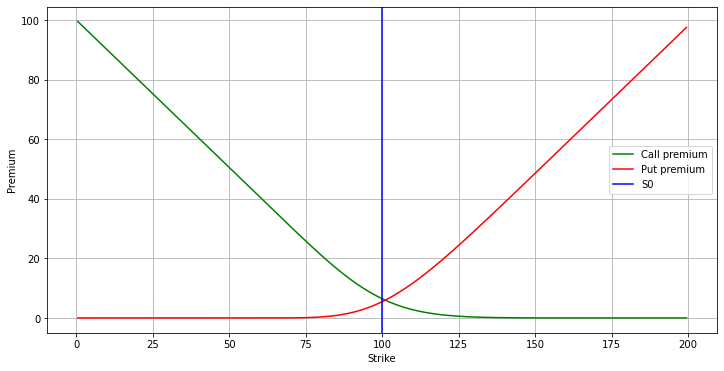

In [183]:
a, b, c = plot_premium_strike(S0, sigma, T, r)

$C = P \Rightarrow K = Se^{rT} > S$ : for the same price you have an ITM put and an OTM call

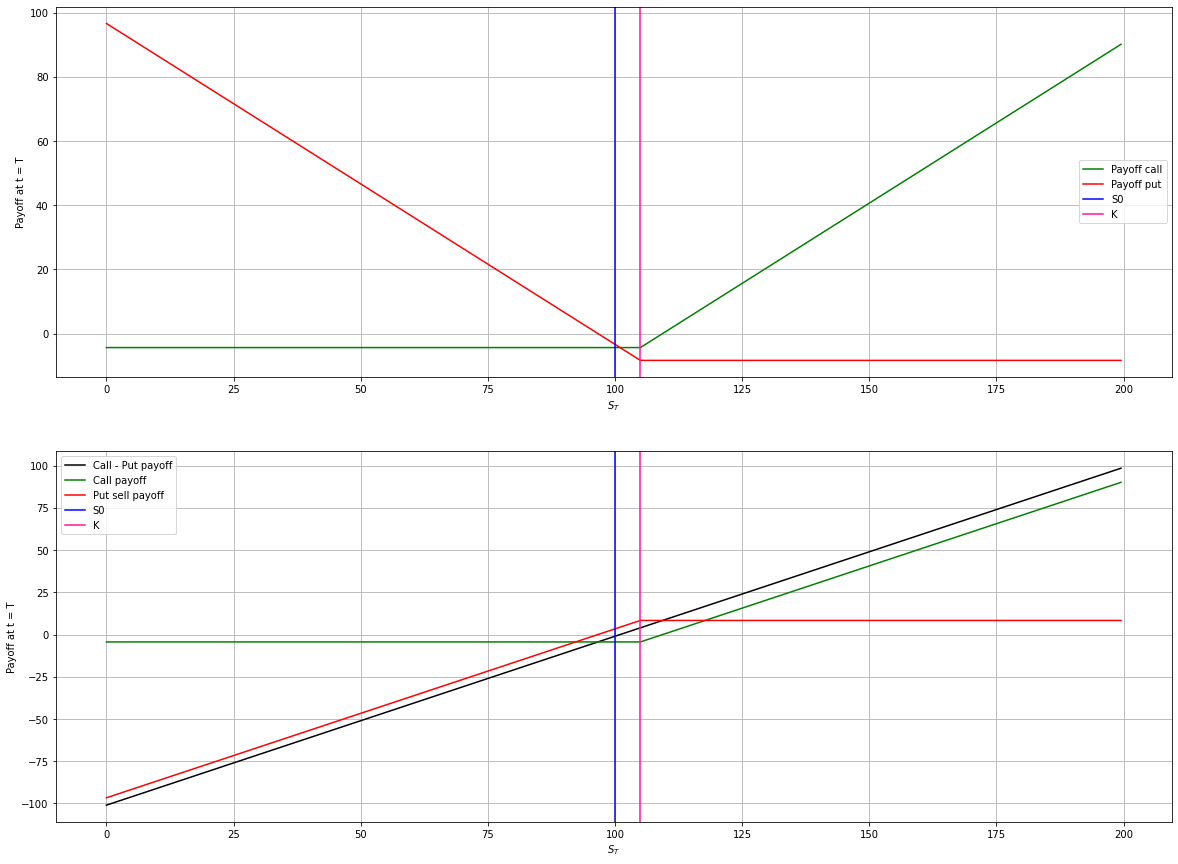

In [189]:
a,b,c,d = plot_payoff(S0, K, sigma, T, r, True)

At $t = 0$ : $V_{t=0} = P - C = e^{-rT}K - S_0 \ (= e^{rT}(P - C) = K - e^{rT}S_0)_{t=T}$ (Sell a put, buy a call) <br>
At $t = T$ : $V_{t=T} = S_T - K$ <br>
So all in all : $V_{t=T} = S_T - K + e^{rT}(P - C) = S_T - e^{rT}S_0 = S_T - F_T$ with $F_T$ the futures value of S at maturity T <br>
Selling a put and buying a call in the same as buying a future

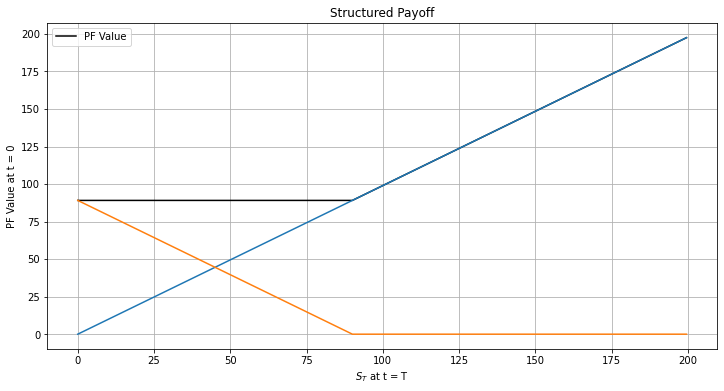

Total premium paid : 1.793865773975078
Total bond cost : 0
Total spot cost : 100
Total initial cost : 101.79386577397509


In [318]:
products = [{"name" : "spot", "params" : [1]},
           {"name" : "option", "params" : ["put", "buy", 90, sigma]}]
a, b, c = plot_structured_payoff(S0, products, r, T, False, True)

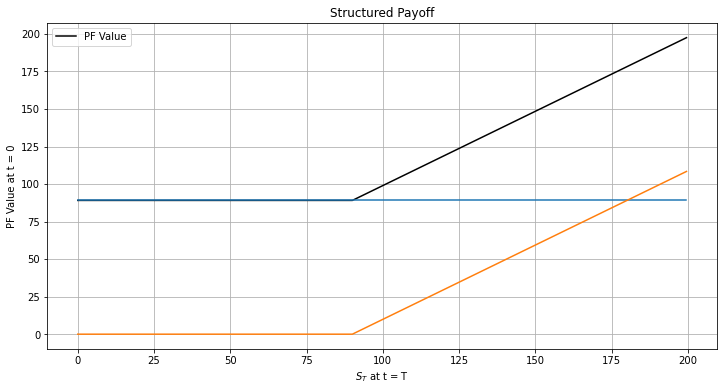

Total premium paid : 12.689380736549936
Total bond cost : 89.10448503742514
Total spot cost : 0
Total initial cost : 101.79386577397507


In [319]:
products = [{"name" : "bond", "params" : [90]},
           {"name" : "option", "params" : ["call", "buy", 90, sigma]}]
a,b,c = plot_structured_payoff(S0, products, r, T, False, True)

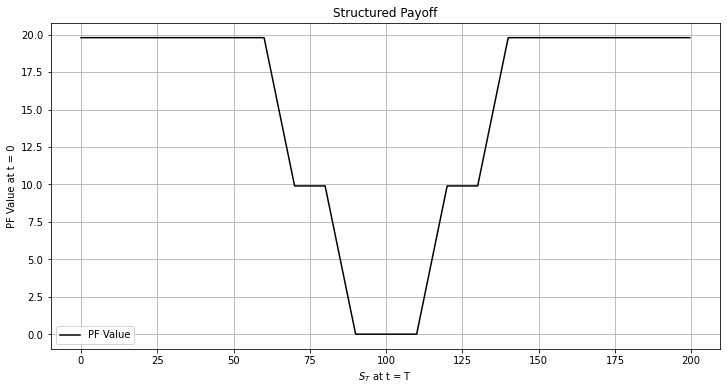

Total premium paid : 3.4672916298407928
Total bond cost : 0
Total spot cost : 0
Total initial cost : 3.4672916298407928


In [323]:
products = [{"name" : "option", "params" : ["put", "buy", 90, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 80, sigma]},
            {"name" : "option", "params" : ["put", "buy", 70, sigma]}, 
            {"name" : "option", "params" : ["put", "sell", 60, sigma]},
            {"name" : "option", "params" : ["call", "buy", 110, sigma]},
            {"name" : "option", "params" : ["call", "sell", 120, sigma]},
            {"name" : "option", "params" : ["call", "buy", 130, sigma]},
            {"name" : "option", "params" : ["call", "sell", 140, sigma]}]
a,b,c = plot_structured_payoff(100, products, r, T, False, False)

In [194]:
S0 = 5000 # Spot price
K = 4000  # Strike price
T = 1     # Time to maturity in years
r = -0.003  # Risk-free rate
sigma = 0.17 # Volatility 
params = [S0, K, sigma, T, r]

In [219]:
# Acheter un put à 4000 et vendre un put à 3000 pour être couvert de -20% à -40%
(put(5000, 4000, 0.17, 1, -0.003) - put(5000, 3000, 0.23, 1, -0.003))*100/5000

0.614224362110335

In [216]:
# Vendre un call à 5250 pour le surplus des 5%
call(5000, 5250, 0.12, 1, -0.003)*100/5000

2.7036517555502586

In [227]:
5*np.ones(5)

array([5., 5., 5., 5., 5.])